<a href="https://colab.research.google.com/github/mariusbiteau/Buildings_Electrical-Consumption_CO2-Emissions_Prediction/blob/main/Analysis_Buildings_Electrical_Consumption_CO2_Emissions_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of electrical consumption and CO2 emissions of non-residential buildings.

You work for the city of Seattle. To achieve its goal of a carbon-neutral city by 2050, your team is taking a close look at emissions from non-residential buildings.

### About the Dataset

This is a dataset hosted by the City of Seattle. The city has an open data platform found here and they update their information according the amount of data that is brought in. 

Update Frequency: This dataset is updated quarterly.

The datasets has as datapoint each building (TBD products) and for each, we have TBD columns which are separated in  sections :

TBD


### Project Goal

Thorough surveys have been carried out by your agents in 2015 and 2016. However, these readings are expensive to obtain, and based on those already taken, you want to try to predict the CO2 emissions and total energy consumption of buildings for which they have not yet been measured.

You are also looking to assess the value of the ENERGY STAR Score for emissions prediction, which is tedious to calculate with the approach your team is currently using.

Objectives of this analysis notebook :

- Perform a brief EDA.
- Test different prediction models in order to better answer the problem.

 have 2 variables to predict; the energy consumption of a site and its CO2 emissions. I also have to evaluate the interest of the Energy Star Score in predicting carbon emissions.

The energy consumption (kWh or kBtu) of a building is composed of different factors, in order of importance :

Its natural characteristics (placement, orientation, etc.),
Its level of insulation (attic, walls, glazing, etc.),
Its airtightness level (VMC, electrical boxes, gaskets, etc... ),
The performance of its equipment (hot water production, user equipment),
Its mode of heating (electricity, gas, wood, etc...)
CO2 emissions are regulated by direct and indirect factors. For example, an electrical energy produced by nuclear fission will emit less CO2 than an electrical energy produced by coal, this is an indirect factor. If heat is produced directly using natural gas, it is a direct factor in CO2 emissions.

We speak of emissions in grams per kWh or kBtu, so CO2 emissions are correlated to energy consumption.

The objective of this first work is to be able to extract the variables that best correspond to the criteria mentioned above, in order to obtain the most efficient models.

In [120]:
from google.colab import drive
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler

## 1. Data Import

In [121]:
drive.mount('/content/drive')
csv_seattle = '/content/drive/My Drive/OC_DataScientist/P4/df_seattle_modelization.csv'
df = pd.read_csv(csv_seattle)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Description

##### Show data header


In [122]:
df.head(3)

,Unnamed: 0,OSEBuildingID,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
0,0,1,MAYFLOWER PARK HOTEL,88,Hotel,1.0,4.0,88434,1.000000,65.0,Electricity,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,7,47.612190,-122.337997
1,1,2,PARAMOUNT HOTEL,19,Hotel,1.0,4.0,103566,0.854547,51.0,NaturalGas,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,7,47.613106,-122.333358
2,2,3,WESTIN HOTEL,46,Hotel,1.0,4.0,961990,1.000000,18.0,Electricity,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,7,47.613349,-122.337699


##### Show data info


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    3102 non-null   int64  
 1   OSEBuildingID                 3102 non-null   int64  
 2   PropertyName                  3102 non-null   object 
 3   BuildingAge                   3102 non-null   int64  
 4   PrimaryPropertyType           3102 non-null   object 
 5   NumberofBuildings             3102 non-null   float64
 6   Binned_Floors                 3078 non-null   float64
 7   PropertyGFATotal              3102 non-null   int64  
 8   GFABuildings_prop             3102 non-null   float64
 9   ENERGYSTARScore               2065 non-null   float64
 10  MainEnergy                    3102 non-null   object 
 11  SiteEnergyUse(kBtu)           3102 non-null   float64
 12  Electricity                   3102 non-null   float64
 13  Nat

##### Fix data types


In [124]:
df.PropertyName = df.PropertyName.astype('category')
df.PrimaryPropertyType = df.PrimaryPropertyType.astype('category')
df.MainEnergy = df.MainEnergy.astype('category')
df = df.drop(['Unnamed: 0'], axis=1)

Now, let's check our new data types and column names:

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 3102 non-null   int64   
 1   PropertyName                  3102 non-null   category
 2   BuildingAge                   3102 non-null   int64   
 3   PrimaryPropertyType           3102 non-null   category
 4   NumberofBuildings             3102 non-null   float64 
 5   Binned_Floors                 3078 non-null   float64 
 6   PropertyGFATotal              3102 non-null   int64   
 7   GFABuildings_prop             3102 non-null   float64 
 8   ENERGYSTARScore               2065 non-null   float64 
 9   MainEnergy                    3102 non-null   category
 10  SiteEnergyUse(kBtu)           3102 non-null   float64 
 11  Electricity                   3102 non-null   float64 
 12  NaturalGas                    3102 non-null   fl

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [126]:
df.describe()

,OSEBuildingID,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
count,3102.000000,3102.000000,3102.000000,3078.000000,3.102000e+03,3102.000000,2065.000000,3.102000e+03,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000
mean,15920.698259,53.815603,1.089297,2.443795,1.145883e+05,0.934572,63.848426,8.030760e+06,0.706203,0.273337,0.020395,0.000044,178.629001,4.382979,47.615868,-122.333445
std,13331.224511,32.743955,1.169077,1.129821,1.977410e+05,0.150500,28.738155,2.082894e+07,0.260824,0.261913,0.089330,0.001321,657.974395,2.202357,0.047740,0.023942
min,1.000000,1.000000,0.000000,1.000000,1.128500e+04,-1.502318,1.000000,1.144100e+04,0.000000,0.000000,0.000000,0.000000,0.080000,1.000000,47.509435,-122.411820
25%,586.500000,27.000000,1.000000,1.000000,2.938000e+04,1.000000,45.000000,1.228871e+06,0.498926,0.000000,0.000000,0.000000,19.822500,2.000000,47.585957,-122.343233
50%,21125.000000,50.000000,1.000000,2.000000,4.885000e+04,1.000000,71.000000,2.602079e+06,0.721463,0.231826,0.000000,0.000000,49.060000,4.000000,47.612276,-122.333223
75%,24535.500000,86.000000,1.000000,3.000000,1.046775e+05,1.000000,88.000000,7.141995e+06,0.999998,0.484631,0.000000,0.000000,140.640000,7.000000,47.648351,-122.322623
max,50226.000000,116.000000,39.000000,4.000000,2.200000e+06,1.000029,100.000000,4.483853e+08,1.000087,1.000000,0.830998,0.046463,16870.980000,7.000000,47.733870,-122.258795


##### Show if there are missing datapoints¶


In [127]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

OSEBuildingID , 0.0
PropertyName , 0.0
BuildingAge , 0.0
PrimaryPropertyType , 0.0
NumberofBuildings , 0.0
Binned_Floors , 0.77
PropertyGFATotal , 0.0
GFABuildings_prop , 0.0
ENERGYSTARScore , 33.43
MainEnergy , 0.0
SiteEnergyUse(kBtu) , 0.0
Electricity , 0.0
NaturalGas , 0.0
SteamUse , 0.0
OtherFuelUse , 0.0
GHGEmissions(MetricTonsCO2e) , 0.0
CouncilDistrictCode , 0.0
Latitude , 0.0
Longitude , 0.0


In [128]:
print(df.isnull().sum())

OSEBuildingID                      0
PropertyName                       0
BuildingAge                        0
PrimaryPropertyType                0
NumberofBuildings                  0
Binned_Floors                     24
PropertyGFATotal                   0
GFABuildings_prop                  0
ENERGYSTARScore                 1037
MainEnergy                         0
SiteEnergyUse(kBtu)                0
Electricity                        0
NaturalGas                         0
SteamUse                           0
OtherFuelUse                       0
GHGEmissions(MetricTonsCO2e)       0
CouncilDistrictCode                0
Latitude                           0
Longitude                          0
dtype: int64


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

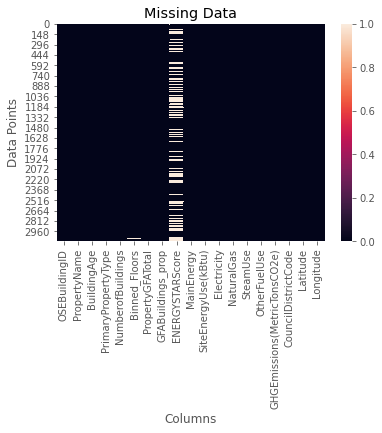

In [129]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the energystar score feature.

We will now process these missing data points

In [130]:
df.loc[df['Binned_Floors'].isnull()]

,OSEBuildingID,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
154,267,PINE ST. CONDO-ELLIOTT GRAND HYATT SEATTLE,16,Hotel,1.0,NaN,934292,1.000000,NaN,Electricity,63811044.00,0.621648,0.378378,0.000000,0.0,1558.85,7,47.612677,-122.333932
464,656,1221 MADISON STREET (FORMER ARNOLD MED. PAVILLON),11,Office,1.0,NaN,225982,1.000000,61.0,Electricity,18558162.00,0.635452,0.000000,0.364574,0.0,604.45,3,47.609680,-122.323105
465,657,2200 WESTLAKE,9,Other,1.0,NaN,516407,1.000000,19.0,Electricity,48981052.00,0.610087,0.389938,0.000000,0.0,1222.69,7,47.617939,-122.337387
536,758,PACIFIC PLACE,16,Other,1.0,NaN,947987,0.535663,NaN,Electricity,48143224.00,1.000041,0.000000,0.000000,0.0,335.63,7,47.612874,-122.335276
910,21611,CHINESE BAPTIST CHURCH,38,Worship Facility,1.0,NaN,21948,1.000000,54.0,Electricity,318205.00,1.000041,0.000000,0.000000,0.0,2.22,2,47.550571,-122.302943
1137,24086,KING COUNTY METRO TRANSIT ATLANTIC-CENTRAL BAS...,24,Other,10.0,NaN,180796,1.000000,NaN,Electricity,29939196.00,0.558467,0.441556,0.000000,0.0,818.66,2,47.591130,-122.323399
1538,40028,"SAND POINT BUILDING 5A,5B,5C,5D",75,Warehouse,1.0,NaN,384772,1.000000,65.0,Electricity,15411831.00,0.579122,0.420902,0.000000,0.0,406.74,4,47.683844,-122.261760
1539,40031,SAND POINT BUILDING 25,55,Office,1.0,NaN,30287,1.000000,56.0,Electricity,1976647.00,0.845482,0.154553,0.000000,0.0,27.88,4,47.682195,-122.262390
1540,40034,SAND POINT BUILDING 29,55,Office,1.0,NaN,21931,1.000000,21.0,NaturalGas,3732139.00,0.351837,0.648178,0.000000,0.0,137.63,4,47.682195,-122.262946
1546,43948,GEORGETOWN STEAM PLANT,109,Other,1.0,NaN,39212,1.000000,NaN,Electricity,773013.00,1.000041,0.000000,0.000000,0.0,5.39,2,47.561588,-122.316071


## 2. EDA

### 2.1 Univariate Analysis: Numerical Variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

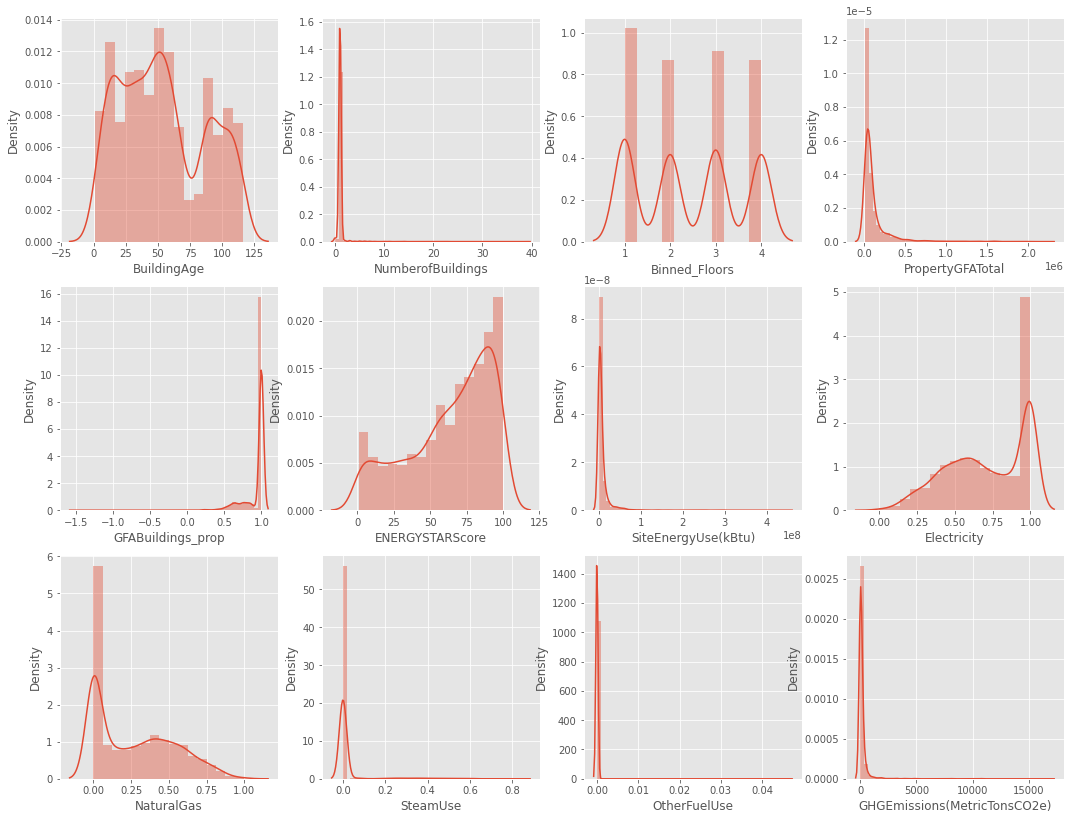

In [131]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ["BuildingAge","NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


[Text(0, 0, 'Office'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Warehouse'),
 Text(0, 0, 'Supermarket/Grocery/Retail Store'),
 Text(0, 0, 'School/University'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Worship Facility'),
 Text(0, 0, 'Distribution Center'),
 Text(0, 0, 'Hospital/Laboratory'),
 Text(0, 0, 'Restaurant')]

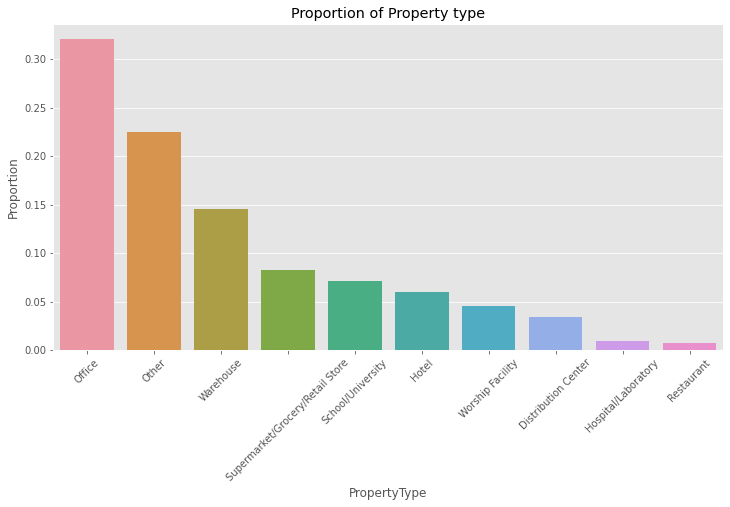

In [132]:
x, y = "PropertyType", "Proportion"

prop_df = (df["PrimaryPropertyType"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Property type')
g.set_xticklabels(g.get_xticklabels(),rotation=45)

[Text(0.5, 1.0, 'Proportion of Main Energy type')]

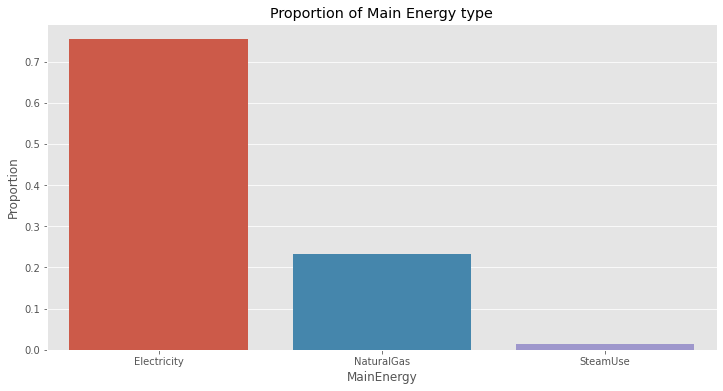

In [133]:
x, y = "MainEnergy", "Proportion"

prop_df = (df["MainEnergy"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Main Energy type')

### 2.3 Multivariate Analysis: Categorical vs Numerical Variables 

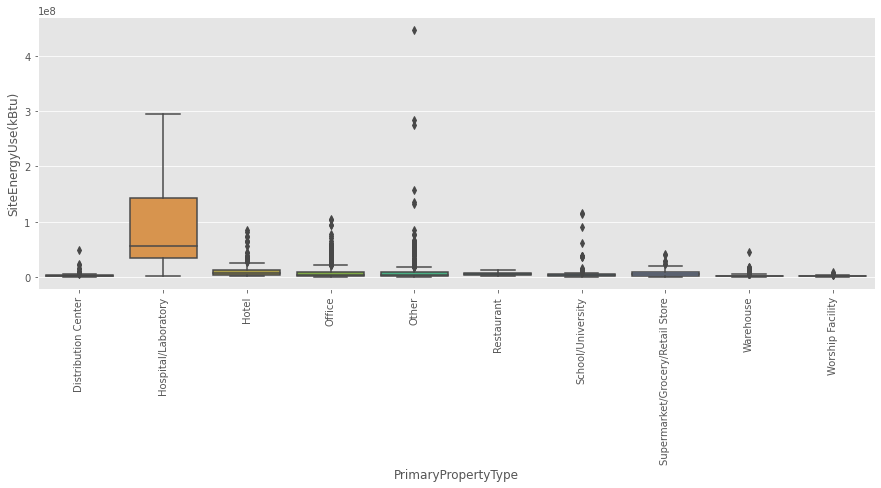

In [134]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

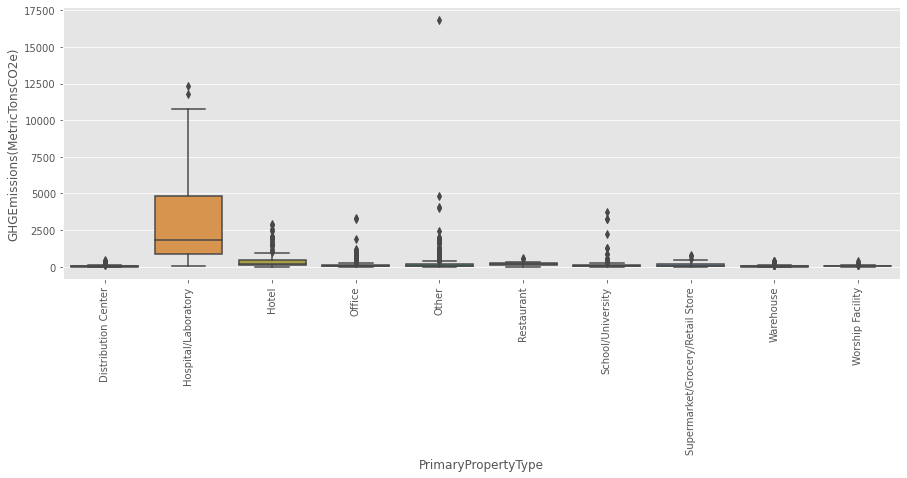

In [135]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

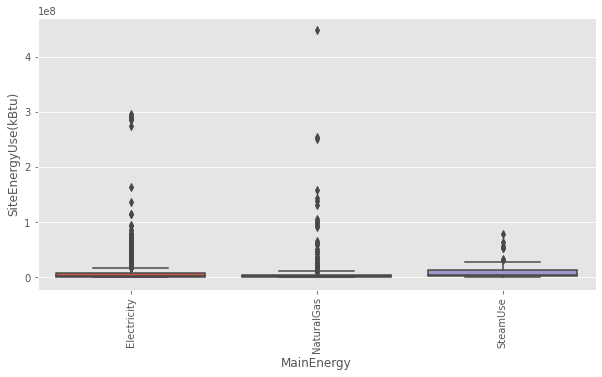

In [155]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

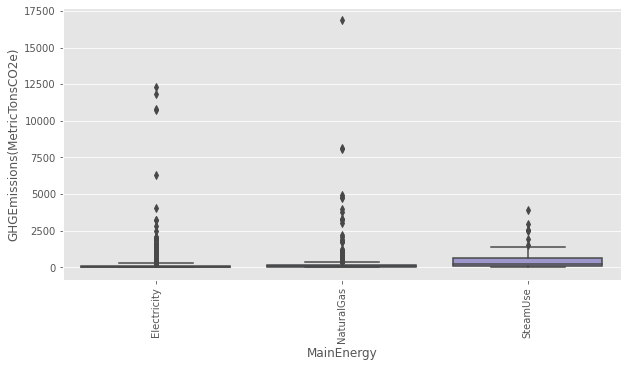

In [156]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

<Figure size 864x864 with 0 Axes>

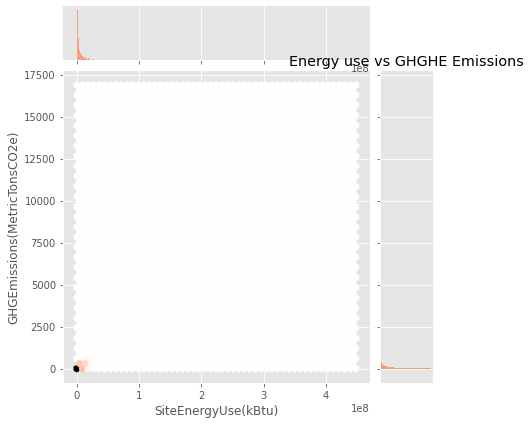

In [158]:
fig = plt.figure(figsize=(12, 12))
sns.jointplot(data=df, x= 'SiteEnergyUse(kBtu)', y= 'GHGEmissions(MetricTonsCO2e)', kind= 'hex',color='coral')
plt.title('Energy use vs GHGHE Emissions')
plt.show()

### 2.4 Geographical Analysis


#### *Heatmap*

In [136]:
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['Latitude'].max() + df['Latitude'].min()) / 2
    centerlong = (df['Longitude'].max() + df['Longitude'].min()) / 2
    return centerlat, centerlong

In [150]:
def generateBaseMap(center = get_center_latlong(df), default_zoom_start=11.5):
    base_map = folium.Map(location = center, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [154]:
from folium.plugins import HeatMap
df['count'] = 1
base_map = generateBaseMap()
HeatMap(data = df[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

#### *Choropleth Map*

In [139]:
boundary_file = '/content/drive/My Drive/OC_DataScientist/P4/Seattle-council-districts.geojson'
with open(boundary_file, 'r') as f:
    district_boundary = json.load(f)

In [152]:
# this line just to force our dataset zipcodes from numbers to strings so they match our geojson file
df['CouncilDistrictCode'] = pd.to_numeric(df.CouncilDistrictCode, errors='coerce')

# Grab my map center again using our created function (same as before)
center = get_center_latlong(df)


# Initialize Folium Map again (same as before)
seattle_map = folium.Map(location=center, zoom_start=11.5)

# Use the groupby method to have the mean of energy use by district
district_data = df.groupby('CouncilDistrictCode').aggregate(np.mean)
district_data.reset_index(inplace = True)

# Create choropleth map  
folium.Choropleth(
    geo_data=district_boundary,
    name='choropleth',
    data=district_data,
    columns=['CouncilDistrictCode', 'SiteEnergyUse(kBtu)'],
    key_on='feature.properties.district',
    fill_color='Spectral',
    fill_opacity=0.60,
      nan_fill_opacity=0,
    line_opacity=0.5,
    legend_name='Energy Use (kBtu)').add_to(seattle_map)

display(seattle_map)

### 2.4 Correlation


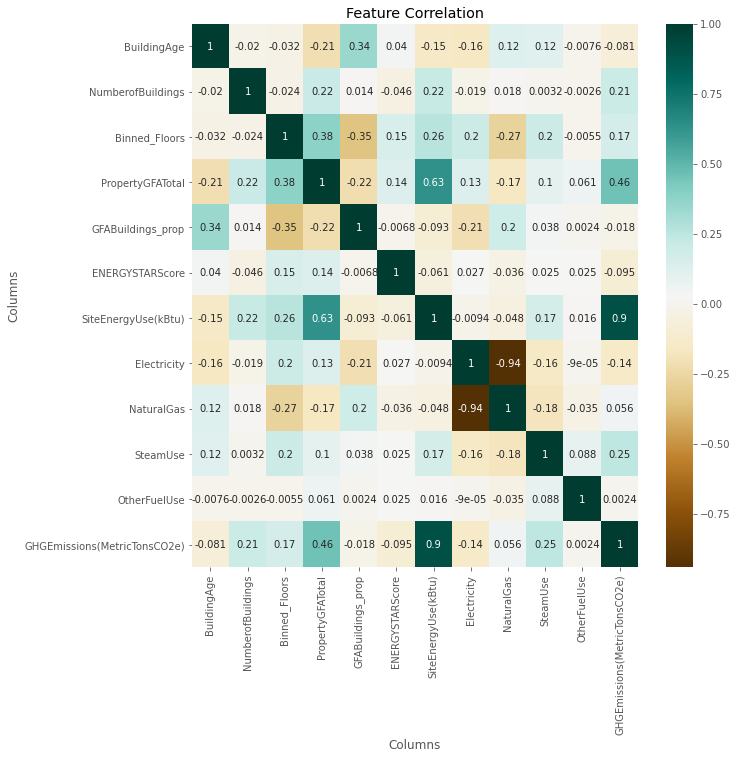

In [141]:
df_corr = df[["BuildingAge", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_corr.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

- Strong correlation between Energy Use and GHGE Emissions
- Medium correlation between energy use and the property GFA total


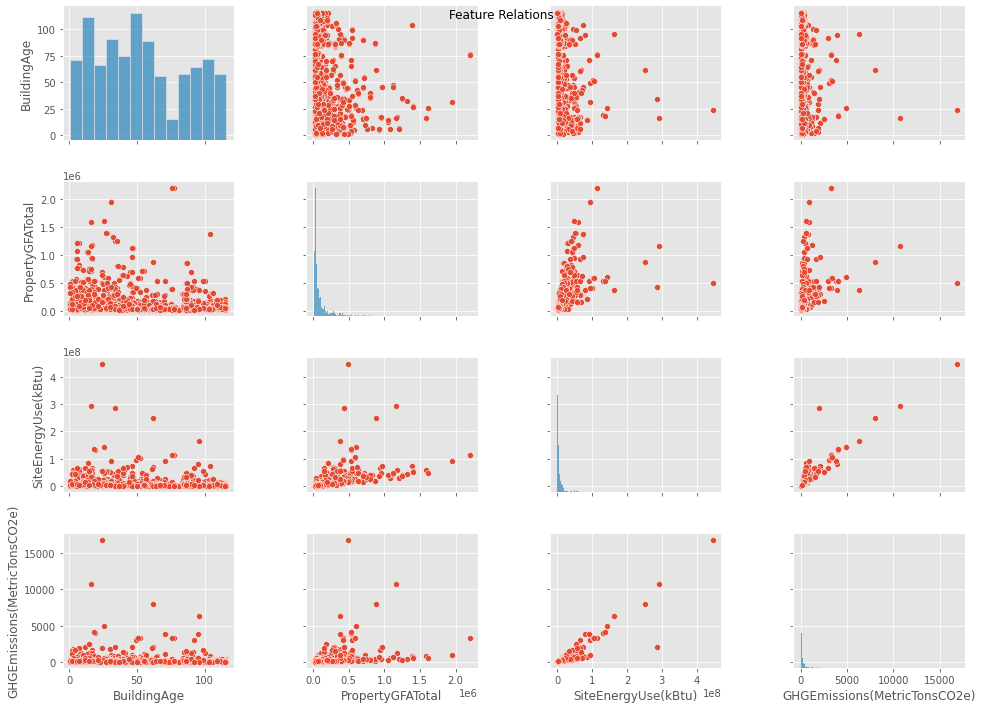

In [142]:
g = sns.pairplot(data=df.loc[index], vars=["BuildingAge", "PropertyGFATotal", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"])
g.fig.suptitle('Feature Relations')
g.fig.set_size_inches(15,10)
plt.show()

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform our cateogrical column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating cateogrical, where it will be used as labels.
3. We will try different splits of our dataset : with/without feature logging ; with.without duplicates.